In [1]:
import gdown
!gdown --id 1-0OQTzDJmEu4ndbXari5K4X5rVPleCyA

Downloading...
From: https://drive.google.com/uc?id=1-0OQTzDJmEu4ndbXari5K4X5rVPleCyA
To: /content/images_color.csv
517MB [00:04, 125MB/s]


In [2]:
import csv
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A

!git clone https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library
%cd Automold--Road-Augmentation-Library

import Automold as am

Cloning into 'Automold--Road-Augmentation-Library'...
remote: Enumerating objects: 170, done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 170
Receiving objects: 100% (170/170), 59.14 MiB | 35.58 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/Automold--Road-Augmentation-Library


# Loading Images

In [3]:
ydata = []
xdata = []

with open('/content/images_color.csv', 'r') as f:
  reader = csv.reader(f)
  for row in reader:
    if row[0]!='':
      label = row[0]
      image = np.array([int(a) for a in row[1:]], dtype = "uint8")
      image = image.reshape((32, 32, 3))
      image = cv2.resize(image,(64, 64))
      xdata.append(image)
      ydata.append(label)

img_data = np.array(xdata)
label_data = np.array(ydata).astype("int")
# print(img_data.shape,label_data.shape)

In [4]:
del ydata, xdata

# Loading Extra Images

In [5]:
# ydata = []
# xdata = []

# with open('/content/extra_images_color.csv', 'r') as f:
#   reader = csv.reader(f)
#   for row in reader:
#     if row[0]!='':
#       label = row[0]
#       image = np.array([int(a) for a in row[1:]], dtype='uint8')
#       image = image.reshape((32, 32, 3))
#       xdata.append(image)
#       ydata.append(label)

# eximg_data = np.array(xdata)
# exlabel_data = np.array(ydata)
# img_data = np.concatenate((img_data, eximg_data), axis=0)
# label_data = np.concatenate((label_data, exlabel_data), axis=0)
# print(img_data.shape,label_data.shape)

# Display fuction

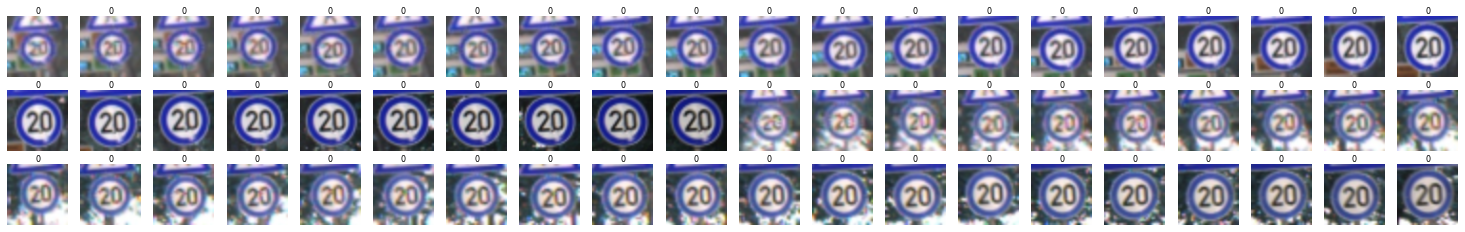

In [6]:
def display_one_sign(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if title != None:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2),
                  color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(images, labels = None):         # Two parameters 1) batch of images, 2) corresponding labels(optional)
  cols = 20
  rows = 1+(images.shape[0]//20)

  if labels is None:
    labels = [None for _ in enumerate(images)]

  FIGSIZE = 26.0
  SPACING = 0.1
  subplot=(rows,cols,1)
  if rows < cols:
    plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
  else:
    plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
  
  for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
    title = label
    correct = True
    dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3
    subplot = display_one_sign(image, title, subplot, not correct, titlesize=dynamic_titlesize)

  plt.show()

display_batch_of_images(img_data[:60], label_data[:60])

# Plot class distribution function

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


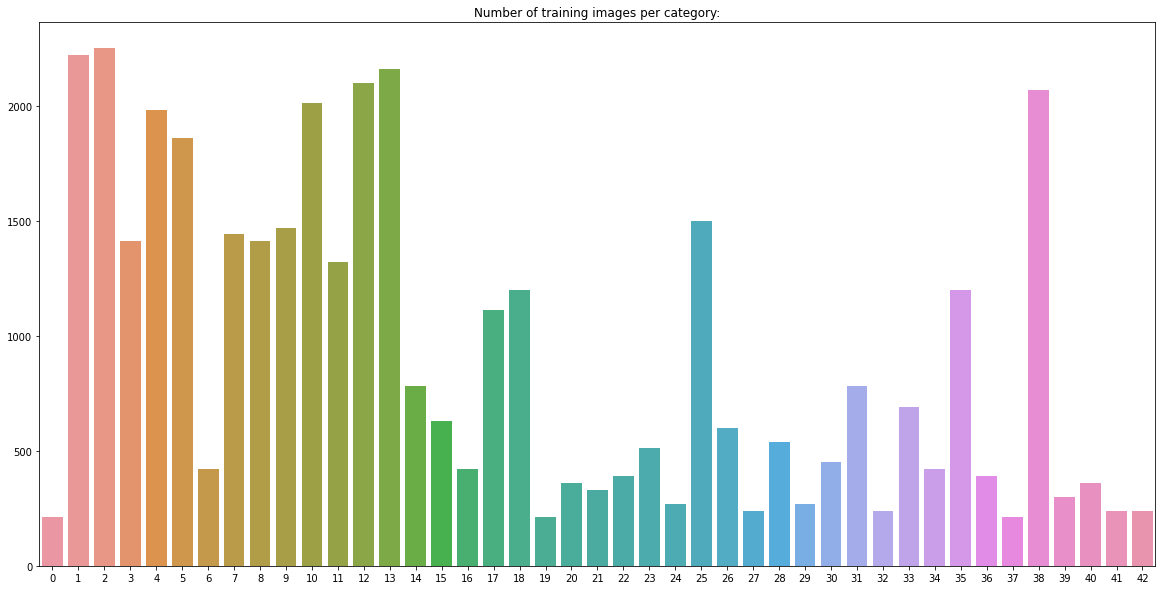

In [7]:
def plot(y):
  category_names = [n for n in range(len(np.unique(y)))]
  label_num = []
  for i in category_names:
    num = sum(y == i)
    label_num.append(num)
  plt.figure(figsize=(20,10))
  sns.barplot(category_names, label_num).set_title("Number of training images per category:")
  plt.show()

plot(label_data)

# Curate Classes

In [8]:
classes_dict = {"Type" : "custom",             # two option "all_same" and "custom"
                "label_data" : label_data,
                "all_same_number" : 1000,        # if option "all_same"
                0: 300,
                5: 1500}                       # if option "custom", similarly for other classes


def curate_classes(cdict):
  labels = cdict["label_data"]
  option = cdict["Type"]
  
  unique, counts = np.unique(labels, return_counts=True)
  del labels
  num_per_class = dict(zip(unique, counts))

  if option == "all_same":
    var_num = {k:cdict["all_same_number"] for k in num_per_class.keys()}
    return var_num
  elif option == "custom":
    var_num = num_per_class.copy()
    for i in num_per_class.keys():
      if i in classes_dict.keys():
        var_num[i] = classes_dict[i]
    return var_num

var_num = curate_classes(classes_dict)

In [9]:
all_aug=['CLAHE', 'Blur', 'Cutout','GaussNoise','HueSaturationValue','ChannelShuffle','GridDistortion','MedianBlur','Normalize','PadIfNeeded','RandomBrightness',
         'RandomBrightnessContrast','RandomContrast','ToGray','ShiftScaleRotate','add_rain','add_snow','add_shadow','darken','random_brightness']

def augment(image, input_aug):
  prob = 0.5
  transforms=[]
  for i in input_aug:
    if i in all_aug:
      if i=='CLAHE':
        clip_limit=8
        tile_grid_size = (10,10)
        transforms.append(A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, always_apply=False, p=prob))
      elif i=='Cutout':
        num_holes=3
        max_h_size,max_w_size=2,2
        transforms.append(A.Cutout(num_holes=num_holes, max_h_size=max_h_size, max_w_size=max_w_size, always_apply=False, p=prob))
      elif i=='GaussNoise':
        var_limit_x,var_limit_y = 10,50
        var_limit = (var_limit_x,var_limit_y)
        transforms.append( A.GaussNoise (var_limit=var_limit,  always_apply=False, p=prob))
      elif i=='HueSaturationValue':
        hue_shift_limit=20
        sat_shift_limit=30
        val_shift_limit=20
        transforms.append(A.HueSaturationValue (hue_shift_limit=hue_shift_limit, sat_shift_limit=sat_shift_limit, val_shift_limit=val_shift_limit, always_apply=False, p=prob))
      elif i=='Blur':
        blur_limit=2
        transforms.append(A.Blur (blur_limit=blur_limit, always_apply=False, p=prob)) 
      elif i=='ChannelShuffle':
        transforms.append(A.ChannelShuffle(p=prob))
      elif i=='GridDistortion':
        num_steps=5
        distort_limit=0.3
        transforms.append(A.GridDistortion (num_steps=num_steps, distort_limit=distort_limit, interpolation=1, border_mode=4,always_apply=False, p=prob))
      elif i=='MedianBlur':
        blur_limit=3
        transforms.append(A.MedianBlur (blur_limit=blur_limit, always_apply=False, p=prob))
      elif i=='Normalize':
        transforms.append(A.Normalize (mean=(0.12, 0.13, 0.14), std=(0.668, 0.699, 0.7), max_pixel_value=70, always_apply=False, p=prob))
      elif i=='PadIfNeeded':
        transforms.append(A.PadIfNeeded (min_height=32, min_width=32,border_mode=4, value=None,  always_apply=False, p=prob))
      elif i=='RandomBrightness':
        limit=0.2
        transforms.append(A.RandomBrightness (limit=limit, always_apply=False, p=prob))
      elif i=='RandomBrightnessContrast':
        brightness_limit=0.2
        contrast_limit=0.2
        transforms.append(A.RandomBrightnessContrast (brightness_limit=brightness_limit, contrast_limit=contrast_limit, always_apply=False, p=prob))
      elif i=='RandomContrast':
        limit=0.2
        transforms.append(A.RandomContrast (limit=limit, always_apply=False, p=prob))
      elif i=='ToGray':
        transforms.append(A.ToGray(p=prob))
      elif i=='ShiftScaleRotate':
        shift_limit=0.0625
        rotate_limit=45
        transforms.append(A.ShiftScaleRotate (shift_limit=shift_limit, scale_limit=0.1, rotate_limit=rotate_limit, interpolation=1, border_mode=4, always_apply=False, p=prob))
      elif i=='add_rain':
        rain_type=random.choice(["heavy", "drizzle"])
        image= am.add_rain(image, rain_type=rain_type, slant=-1,drop_length=1,drop_width=1)
      elif i=='add_snow':
        snow_coeff=0.3
        image= am.add_snow(image, snow_coeff=snow_coeff) 
      elif i=='add_shadow':
        no_of_shadows=2
        image= am.add_shadow(image, no_of_shadows=no_of_shadows)
      elif i=='darken':
        darkness_coeff=0.4
        image= am.darken(image, darkness_coeff=darkness_coeff)
   
  transform=A.Compose(transforms)
  transformed = transform(image=image)
  transformed_image = transformed["image"]
  return transformed_image

In [10]:
def augment_batch(images, input_aug):               # batch of images to be augmented in numpy format
  for i in range(images.shape[0]):
    images[i] = augment(images[i], input_aug)
  return images                                     # return augmented images in numpy format

def create_data_over(img_data, label_data, i, diff, input_aug):
  mask = [int(x)==i for x in label_data.tolist()]
  images1 = img_data[mask]
  del img_data
  label1 = label_data[mask]
  del label_data
  if diff < images1.shape[0]:
    idx = np.random.randint(images1.shape[0], size = diff)
    images2 = augment_batch(images1[idx], input_aug)
    label2 = label1[idx]
    images = np.concatenate((images1, images2), axis=0)
    labels = np.concatenate((label1, label2), axis=0)
    return images, labels
  else:
    n = diff//images1.shape[0]
    diff = diff%images1.shape[0]
    idx = np.random.randint(images1.shape[0], size = diff)
    images2 = [images1]*n
    images2.append(images1[idx])
    images3 = np.concatenate(images2, axis=0)
    images3 = augment_batch(images3, input_aug)
    label2 = [label1]*n
    label2.append(label1[idx])
    label3 = np.concatenate(label2, axis=0)
    images = np.concatenate((images1, images3), axis=0)
    labels = np.concatenate((label1, label3), axis=0)
    return images, labels

def create_data_under(img_data, label_data, i, diff):
  mask = [int(x)==i for x in label_data.tolist()]
  images = img_data[mask]
  del img_data
  labels = label_data[mask]
  del label_data
  idx = np.random.randint(images.shape[0], size = labels.shape[0] - diff)
  images = images[idx]
  labels = labels[idx]
  return images, labels

In [11]:
input_aug = ['Blur', 'Cutout','ChannelShuffle','GridDistortion','MedianBlur','Normalize','PadIfNeeded','RandomBrightness', 'RandomBrightnessContrast',
             'RandomContrast','add_rain','add_snow','random_brightness']

data_dict = {"classn_dict" : var_num,         # var_num curate_classes function
             "img_data": img_data,
             "label_data": label_data,
             "input_aug": input_aug}          # user selected augmentations

def final_data(ddict):
  var_num = ddict["classn_dict"]
  img_data = ddict["img_data"]
  label_data = ddict["label_data"]

  unique, counts = np.unique(label_data, return_counts=True)
  num_per_class = dict(zip(unique, counts))

  images_lst = []
  labels_lst = []

  for i in range(len(unique)):
    diff = var_num[i] - num_per_class[i]
    if diff == 0:
      mask = [int(x)==i for x in label_data.tolist()]
      images = img_data[mask]
      labels = label_data[mask]
      images_lst.append(images)
      labels_lst.append(labels)
    elif diff > 0:
      images, labels = create_data_over(img_data, label_data, i, diff, ddict["input_aug"])
      images_lst.append(images)
      labels_lst.append(labels)
    elif diff < 0:
      images, labels = create_data_under(img_data, label_data, i, -diff)
      images_lst.append(images)
      labels_lst.append(labels)

  del img_data, label_data

  X_data = np.concatenate(images_lst, axis=0)
  del images_lst
  Y_data = np.concatenate(labels_lst, axis=0)
  del labels_lst

  return X_data, Y_data                       # final Data

X, Y = final_data(data_dict)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


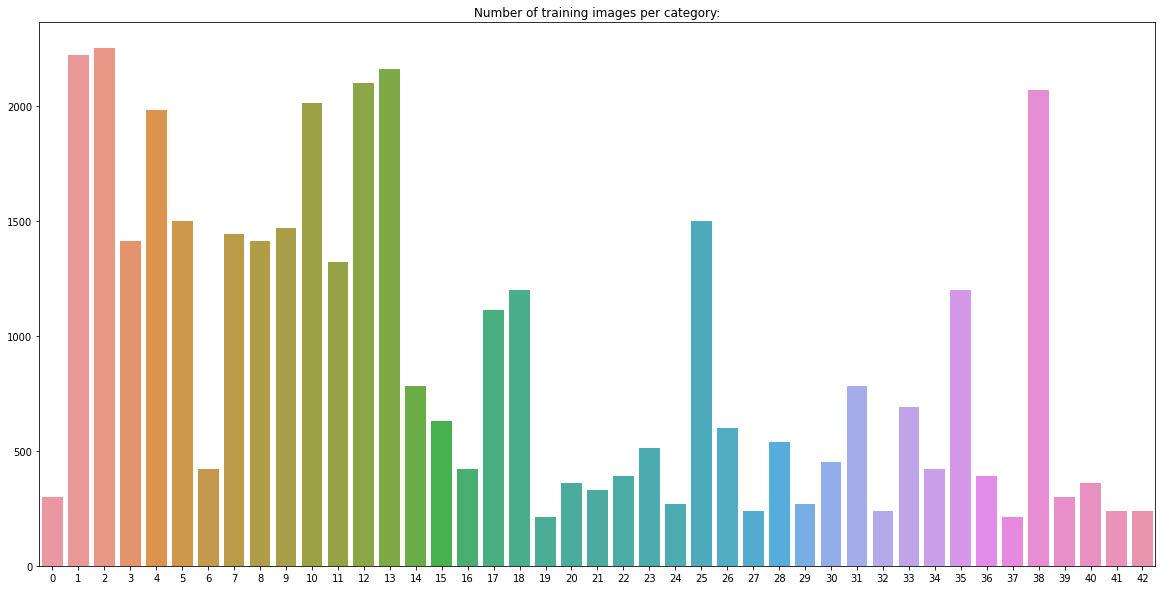

In [12]:
plot(Y)

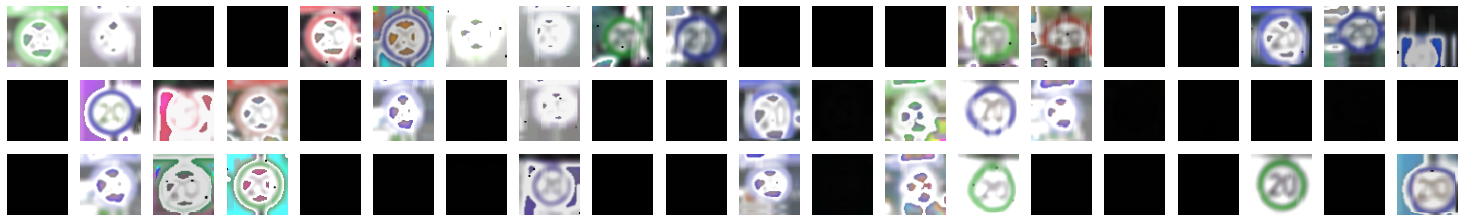

In [13]:
display_batch_of_images(X[240:300])